# Disappearing Forests - Milestone 2


## Introduction
In this notebook, we would try to answer these research questions using our data analysis skills. To do so, we set up some goals to achieve:
- Identify the trend of deforestation in the world
- Find the most deforested countries/areas
- Investigate the deforestation in the most forested countries
- Find the biggest producer of wood and investigate the impact of wood mining on deforestation
- Look for the biggest importer/exporter in the world and the connection among them
- Search for correlation between agriculture industry/animal husbandry and deforestation

## Index
0. **Data Preprocessing**

1. **The Deforestation Trend**
   
   1.1 Forests in each country
   
   1.2 Deforestation in each country
   
   1.3 Land distribution and explanation of changes in forest land share
   
2. **The Wood Trade**

3. **Is agricultural industry influencing deforestation?**

   3.1 Expansion of Agricultural Area
   
   3.2 Link between yield of agricultural land and deforestation
   
   3.3 Clustering of the countries based on agricultural production share
   
4. **Future Work**

## **0. Data Preprocessing**
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`. Here is the list of the datasets that we would work on (you can check for a **more detailed description in the appendix** at the end of the notebook).

- `Inputs_LandUse_E_All_Data_cleared.csv`
- `Environment_LandCover_E_All_Data_cleared.csv`
- `Environment_LandUse_E_All_Data_cleared.csv`
- `Environment_LivestockPatterns_E_All_Data_cleared.csv`
- `Forestry_E_All_Data_cleared.csv`
- `Forestry_Trade_Flows_E_All_Data_cleared.csv`
- `FAOSTAT_countries.csv`

In [1]:
# all the necessary imports
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook, export_png
from bokeh.models import Slider, HoverTool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from bokeh.layouts import widgetbox, row, column
import geopandas as gpd
import json

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
# FAOSTAT are splitted into multiple groups
# FAOSTAT_countries consists of names of the countries
# FAOSTAT_country_groups consists of bigger regions, such as (Europe, Americas, East Europe etc.)
FAOSTAT_country_data = pd.read_csv("data/faostat/FAOSTAT_countries.csv", engine='python')
FAOSTAT_country_groups = FAOSTAT_country_data["Country Group"].unique()
FAOSTAT_countries = FAOSTAT_country_data["Country"].unique()
CONTINENTS = ['Africa', 'Asia', 'Oceania', 'Europe', 'Northern America', 'South America', 'Antarctic Region']

## **1. The Deforestation Trend**
In this section, we try to explore in the data set `Inputs_LandUse_E_All_Data_cleared.csv` to find out related information about forestation and deforestation in each country. Ultimately, we would like to figure out the trend of deforestation over the time span in each country.

### **1.1 Forests in each country**
In this part, we would dive into the dataset `Inputs_LandUse_E_All_Data_cleared.csv` to see forest situation in the nations around the globe, intending to compare the distribution among them.

In [3]:
# select forestation related features from Inputs_LandUse 
LAND_USE_FOREST_ITEMS = ['Forestry']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# change Area USSR to Russian Federation
land_use.Area = np.where(land_use['Area'] == 'USSR', 'Russian Federation', land_use.Area)

In [10]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly_unstack = forested_area_yearly.unstack("Year")

Here we present **top 5 countries ranked by forest land surface** (those having top 5 most important forestation matching to the record in [**Wiki**](https://en.wikipedia.org/wiki/List_of_countries_by_forest_area)). Specifically, we would take a look at their forest areas **from 1990 to 2017**.

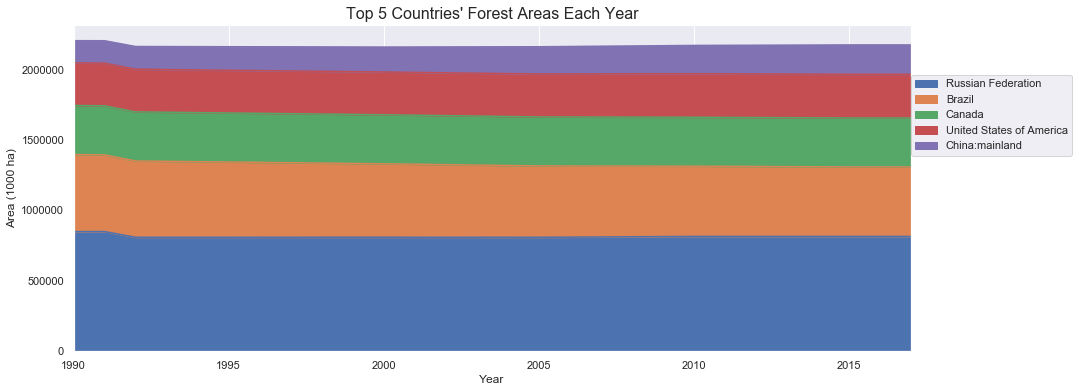

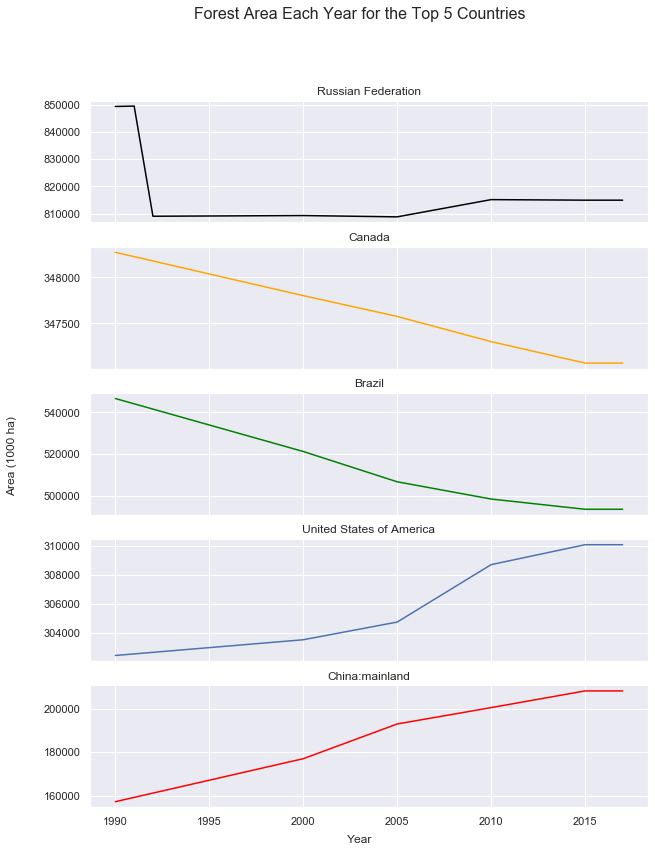

In [11]:
# plot the forest area of top 5 countries containing most important forestation 
forested_area_yearly_unstack.loc[['Russian Federation', 'Brazil', 'Canada', 'United States of America', 'China:mainland'], :]\
                            .T.plot.area(figsize = (15, 6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title("Top 5 Countries' Forest Areas Each Year", fontsize = 16)
plt.show()

# look in more detailed for those top 5
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly.loc['Russian Federation'], color = 'black')
axes[1].plot(forested_area_yearly.loc['Canada'], color = 'orange')
axes[2].plot(forested_area_yearly.loc['Brazil'], color = 'green')
axes[3].plot(forested_area_yearly.loc['United States of America'])
axes[4].plot(forested_area_yearly.loc['China:mainland'], color = 'red')
axes[0].set_title('Russian Federation')
axes[1].set_title('Canada')
axes[2].set_title('Brazil')
axes[3].set_title('United States of America')
axes[4].set_title('China:mainland')
fig.suptitle("Forest Area Each Year for the Top 5 Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in the plot, both **Brazil and Canada have decreasing forest areas** in every coming year. Anyway, the **drop in percentage for Brazil is much bigger** than the one for Canada.
- On the contrary, **USA and China exhibit a postive trend** of increasing forest areas.
- As for **Russia**, we can see that there is a sudden drop from 1990, which may result from **dissolution of Soviet Union** and reduce the forest areas in Russia. Reference [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union).

Overall, to get the insight from broader side, we would like to create a **world map showing the forest percentage in every country**. Take the year in **2016** as an example.

In [13]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "Country"] = "China"
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "SDN"

# load 'Environment_LandUse_E_All_Data_cleared.csv' data set and filter columns
env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')
env_land_use = env_land_use_all[env_land_use_all.Item.isin(['Forest land']) & env_land_use_all.Element.str.match("Share in Land area")][["Area", "Year", "Value"]]

# join the codes to the countires
env_land_use = env_land_use.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
env_land_use_2016 = env_land_use[env_land_use['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(env_land_use_2016, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlGn'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 70)
# define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '40%', '45': '45%' , '50': '50%', '55': '55%', '60': '>60%'}

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('% Forrested area', '@Value')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
# create figure object
p = figure(title = 'Share of forrest, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# save image
export_png(p, filename = 'data/images/share-of-forest-2016.png')
# display figure
show(p)

Loading BokehJS ...

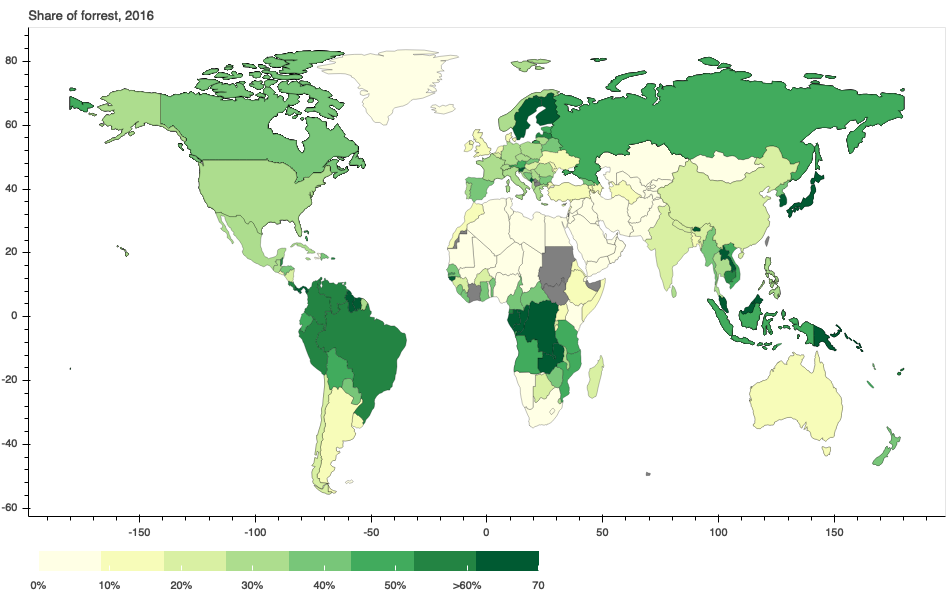

In [14]:
# since we are using the module, bokeh, which may not be seen in the notebook originally
# thus, we save the image so that readers could check it anyway
from IPython.display import Image
Image('data/images/share-of-forest-2016.png')

Next, from the broader view, we would like to check the forest areas **in each continent**.

In [8]:
# forest areas in continents over years
continents_forests_area = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)].groupby(["Area", "Year"]).Value.sum()

continents_forests_area_unstack = continents_forests_area.unstack("Year")

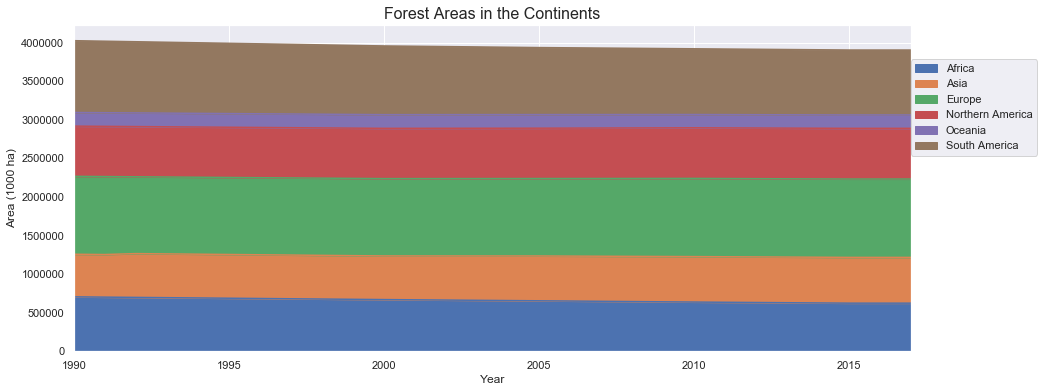

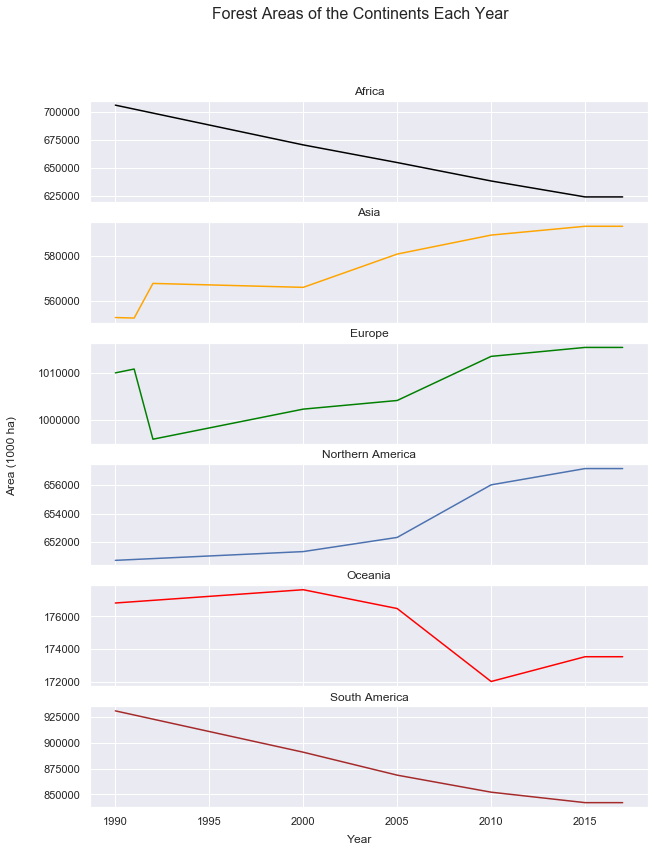

In [9]:
# plot forested areas in continents over the years
continetns_forests_plot = continents_forests_area_unstack.T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title('Forest Areas in the Continents', fontsize = 16)
plt.show()

# look deeper for each continent
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 13))
axes[0].plot(continents_forests_area.loc['Africa'], color = 'black')
axes[1].plot(continents_forests_area.loc['Asia'], color = 'orange')
axes[2].plot(continents_forests_area.loc['Europe'], color = 'green')
axes[3].plot(continents_forests_area.loc['Northern America'])
axes[4].plot(continents_forests_area.loc['Oceania'], color = 'red')
axes[5].plot(continents_forests_area.loc['South America'], color = 'brown')
axes[0].set_title('Africa')
axes[1].set_title('Asia')
axes[2].set_title('Europe')
axes[3].set_title('Northern America')
axes[4].set_title('Oceania')
axes[5].set_title('South America')
fig.suptitle("Forest Areas of the Continents Each Year", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- From the plot, both **Africa and South America steadily reduced** their forest area over the years.
- Similarly but slightly bizarrely, we can see that the trend in **Oceania** went upward at first (until 2000) but then **dropped sharply** in 2005. We doubt that there may be some interesting factors causing this phenomenon.
- In contrast, the rest such as **Asia, Europe, and North America expanded** their forest areas.
- The most recent years (from 2015 on) exhibit completely flat trend: there could be a **problem in the dataset we'll need to fix**.

### **1.2 Deforestation in each country**
In this part, we focus on examining the **reduction of forests in every country** from 1990 to 2017. We compared the reduction between the first year and the last year, using again the dataset `Inputs_LandUse_E_All_Data_cleared.csv`.

In [11]:
# helpful functions to extract first and last non-null values
def first(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
    
def last(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x[x.last_valid_index()]

In [12]:
# top 5 countries which have deforestated most of forested areas over these years
forested_areas_diff = forested_area_yearly_unstack.apply(first, axis=1) - forested_area_yearly_unstack.apply(last, axis=1)
forested_areas_diff = forested_areas_diff.sort_values(ascending=False)
forested_areas_diff.head()

Area
Brazil                53167.0
Russian Federation    34493.9
Indonesia             27535.0
Nigeria               10241.0
Myanmar               10177.0
dtype: float64

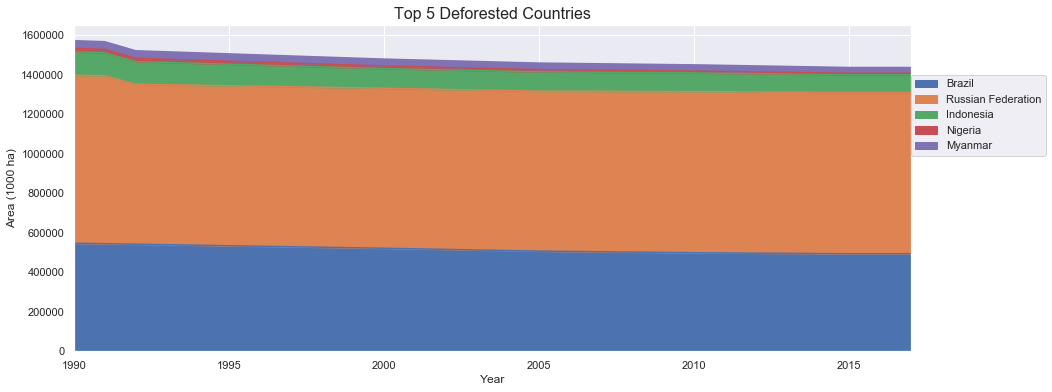

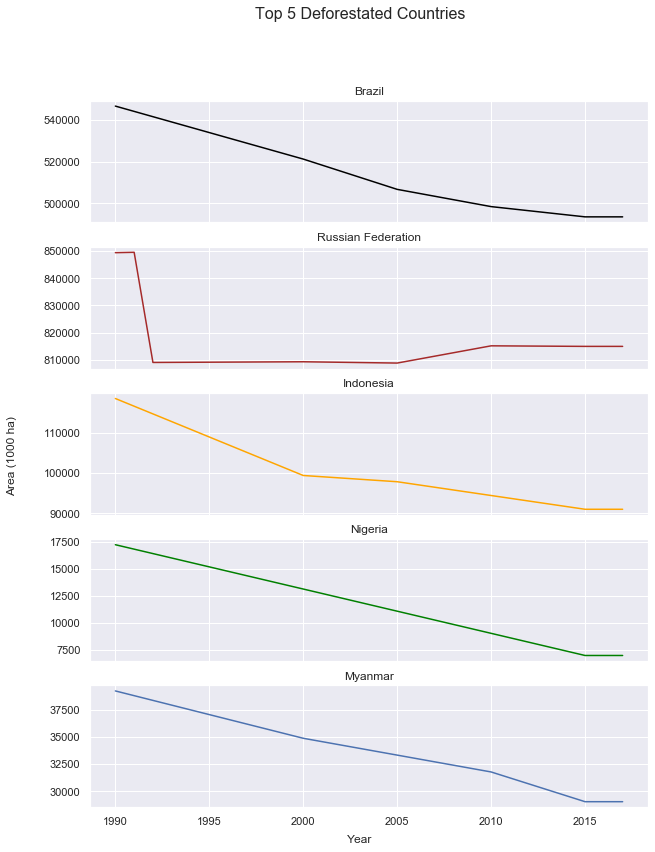

In [13]:
# top 5 countries which have deforestated most of forested areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Russian Federation'], color = 'brown')
axes[2].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[3].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[4].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[0].set_title('Brazil')
axes[1].set_title('Russian Federation')
axes[2].set_title('Indonesia')
axes[3].set_title('Nigeria')
axes[4].set_title('Myanmar')
fig.suptitle("Top 5 Deforestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- We notice that the **rapid reduction in Russia** is mainly from 1991 to 1992. We speculate that the reason why Russia decreased much forests areas at that time is due to the **collapse of Soviet Union**, shrinking Russia's territory. We remove Russia to exclude the political issue. More details [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union)

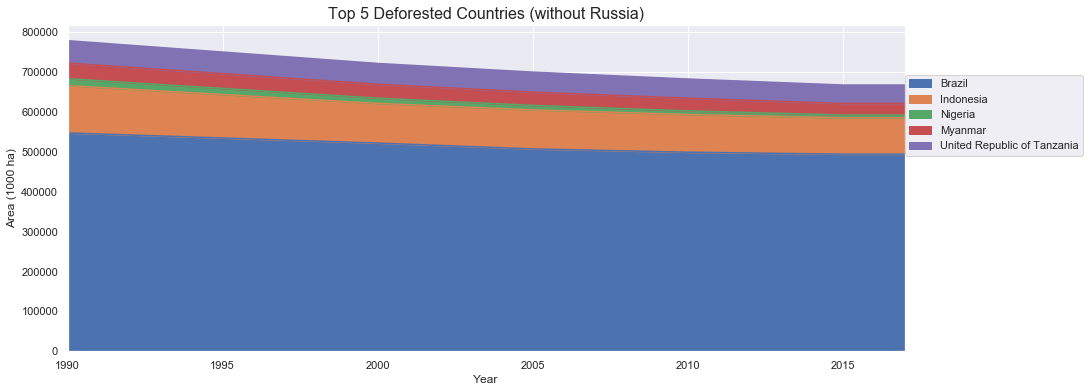

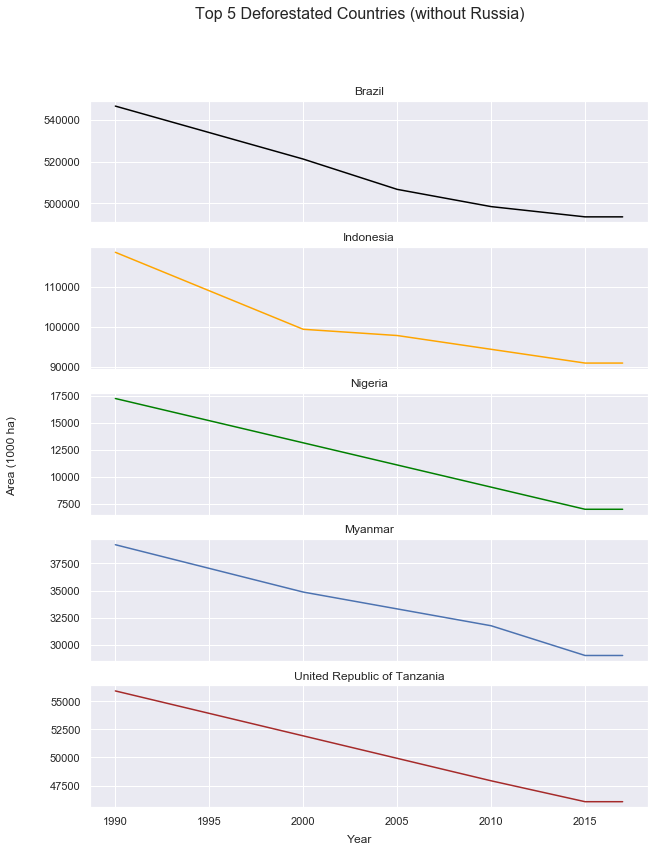

In [14]:
# top 5 countries which have deforestated most of forested areas over the years (without Russia)
forested_area_yearly_unstack.loc[forested_areas_diff[[0, 2, 3, 4, 5]].index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries (without Russia)', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[4].plot(forested_area_yearly_unstack.loc['United Republic of Tanzania'], color = 'brown')
axes[0].set_title('Brazil')
axes[1].set_title('Indonesia')
axes[2].set_title('Nigeria')
axes[3].set_title('Myanmar')
axes[4].set_title('United Republic of Tanzania')
fig.suptitle("Top 5 Deforestated Countries (without Russia)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in both plots, these top 5 deforested countries have been all **monotonically decreasing** their forest areas (with almost the same trend).
- At first, **Indonesia** had more rapid deforestation trend; however, after 2000, the **trend slowed down**.

In [15]:
# top 5 countries with biggest expansion of forests (Note: Russian Federation seems as an outlier)
forested_areas_diff.tail()

Area
Spain                       -4608.38
Viet Nam                    -5410.00
India                       -6743.00
United States of America    -7645.00
China:mainland             -51180.70
dtype: float64

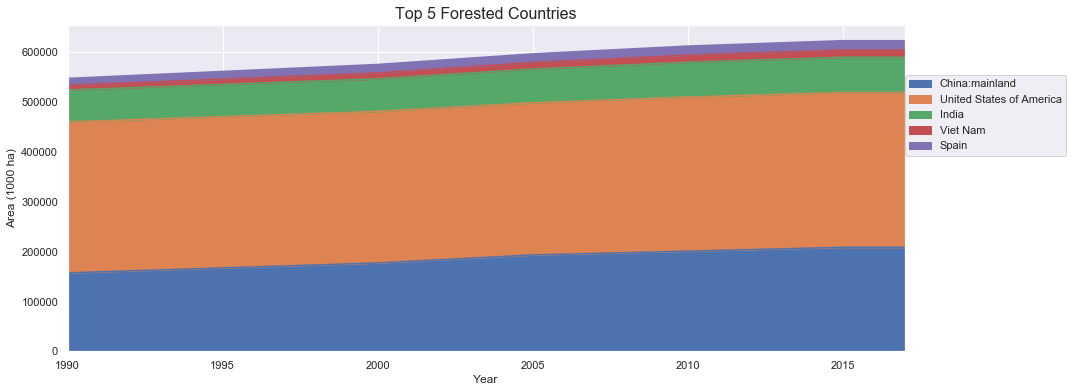

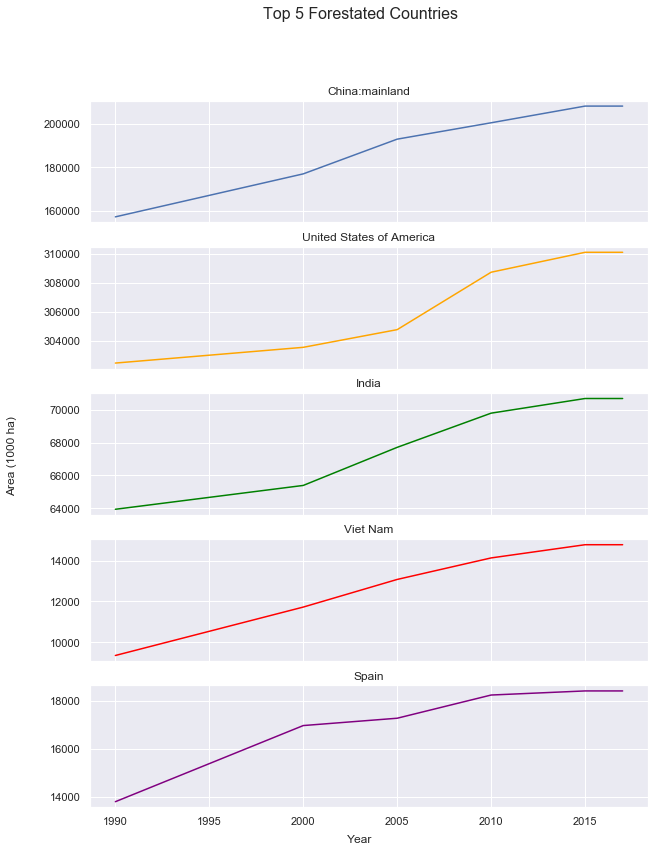

In [16]:
# top 5 countries which have forestated forest areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.sort_values(ascending= True).head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Forested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['China:mainland'])
axes[1].plot(forested_area_yearly_unstack.loc['United States of America'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['India'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Viet Nam'], color = 'red')
axes[4].plot(forested_area_yearly_unstack.loc['Spain'], color = 'purple')
axes[0].set_title('China:mainland')
axes[1].set_title('United States of America')
axes[2].set_title('India')
axes[3].set_title('Viet Nam')
axes[4].set_title('Spain')
fig.suptitle("Top 5 Forestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- Suprisingly, most of top 5 countries with **fast-growing forest areas are developing countries** such as **China, India, and Vietnam**.

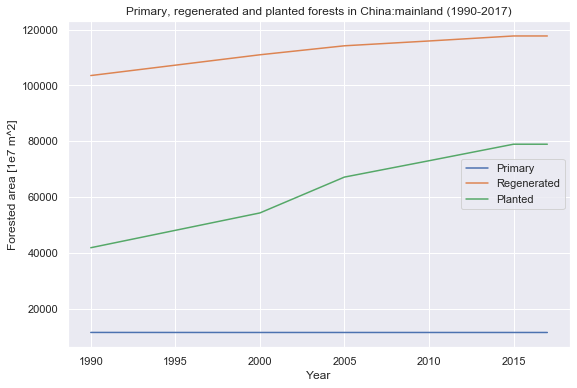

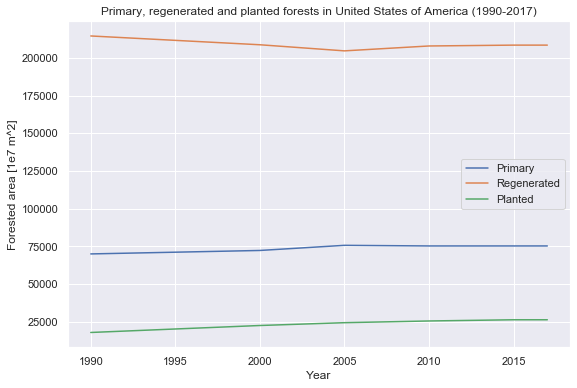

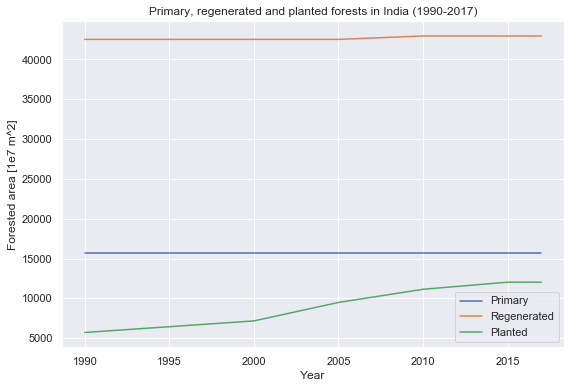

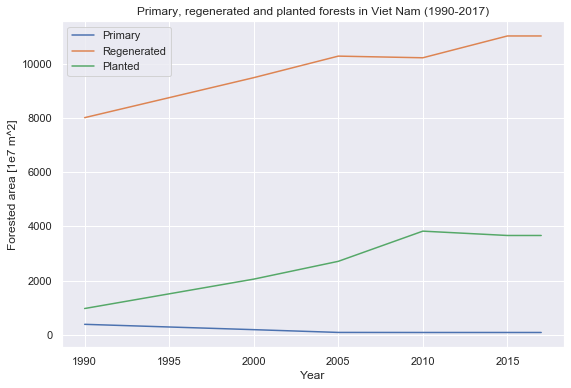

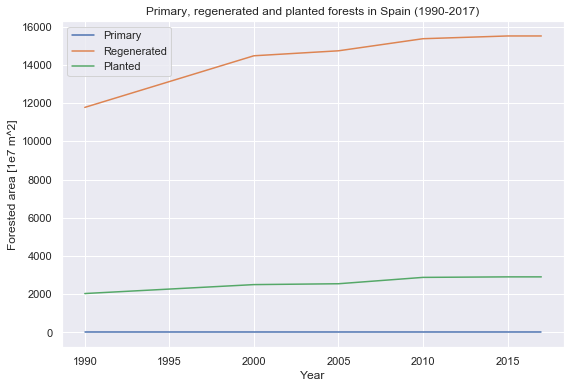

In [18]:
# plot the three kinds of forest (primary, regenerated and planted) for the selected country
LAND_USE_PARTIAL_FOREST_ITEMS = ['Primary Forest', 'Other naturally regenerated forest', 'Planted Forest']
land_use_detail = land_use_all[land_use_all.Item.isin(LAND_USE_PARTIAL_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# plot three types of trees for China
COUNTRY = 'China:mainland'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for USA
COUNTRY = 'United States of America'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for India
COUNTRY = 'India'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for Vietnam
COUNTRY = 'Viet Nam'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for Spain
COUNTRY = 'Spain'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

> #### ***Explanation***
- From our investigation on these types of trees for each country, **China and India** could increase their forest area mainly because of **planted trees**.
- In **USA** overall forests are expanding even if the **regenerated ones are shrinking**.
- **Vietnam** and **Spain** rely on **both regenerated and planted** forests increase.

In this section, we try to research on the dataset `Environment_LandUse_E_All_Data_cleared.csv` to find out ***percentage*** of forestation and deforestation in each country. Still, we would like to figure out the trend of deforestation in percentage over the time span in each country.

In [25]:
# load ENV LansUse and select share of the forests in the each Area per yesr 
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 
                       'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly = env_land_use_yearly.unstack("Year").fillna(method="backfill", axis=0)

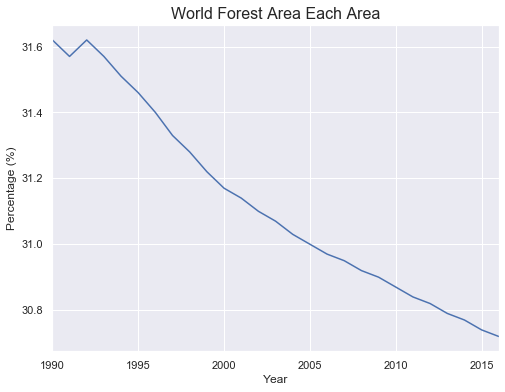

In [26]:
# plot the percentage of world forest areas 
env_land_use_yearly.loc['World'].plot(figsize = (8, 6))
plt.title('World Forest Area Each Year', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Sadly,  the world forest percentage is continuously decreasing, and it has dropped almost **1 percent since 1990s**.
- More specifically, total deforestation area is equalivent to almost **30 times the territory of Switzerland**.

In [27]:
# compute the percentage of deforestation for each country
env_land_use_diff = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 0]\
                                        - env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]

env_land_use_diff = env_land_use_diff.sort_values(ascending=False)

In [28]:
# top 5 countries which have deforestated by % of deforestated areas
env_land_use_diff.head()

Area
Pacific Islands Trust Territory    80.36
Serbia                             57.29
Azerbaijan                         37.35
Honduras                           32.74
USSR                               29.07
dtype: float64

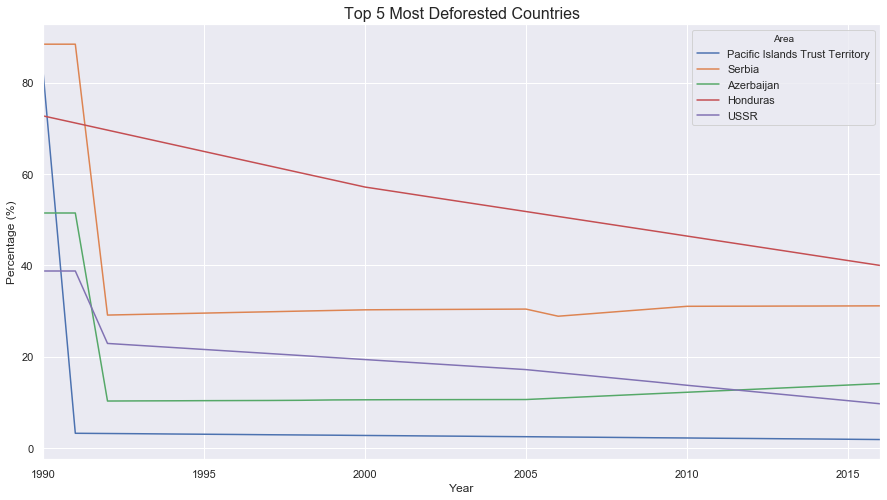

In [30]:
# plot the top 5 countries with most deforestation
env_land_use_yearly.loc[env_land_use_diff.head().index].T.plot(figsize=(15,8))
plt.title('Top 5 Most Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Top 5 countries except Honduras had decreased their forest percentage during early 1900s, and after that, these percentages remain stable to 2017. This can be, again, because of **dissolution of Soviet Union and Yugoslav**.

In [31]:
# show top 5 least deforested countries
env_land_use_diff.tail()

Area
Belgium-Luxembourg                 -36.43
Russian Federation                 -36.87
Micronesia (Federated States of)   -42.36
Netherlands Antilles (former)      -44.42
Sudan (former)                     -85.33
dtype: float64

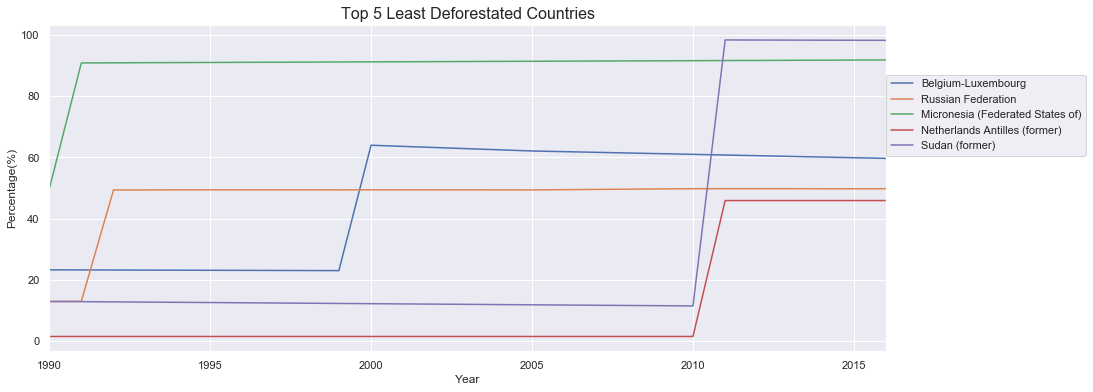

In [33]:
# plot the line graph to show the trend
env_land_use_yearly.loc[env_land_use_diff.tail().index].T.plot(figsize=(15,6))
plt.title('Top 5 Least Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage(%)')
plt.legend(loc = (1, 0.6))
plt.show()

> #### ***Explanation***
- We could observe that instead of growing steadily, the trends of all top 5 deforestated countries have a sudden jump in different times, making their forest areas change rapidly within few years.
- **Belgium-Luxembourg** is an aggregation, **Sudan** and **Netherlands Antilles** have a 'former' tag, **Russian Federation** didn't exist as a whole after 1991.

### **1.3 Land distribution and explanation of changes in forest land share**
In this section we used the dataset `Environment_LandCover_E_All_Data_cleared.csv` which contains two types of measurements: CCI_LC and MODIS. The land distribution is inferred from satellite images and aggregated in different (not always perfectly consistent) ways. We want to analyse **changes in different land types with respect to the "ground level" in 1992** (for CCI_LC, or 2001 for MODIS).

In [3]:
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

In [97]:
# type of land use: comparison between different land types and deduction of 
# how the forested areas ('Tree-covered ares') transformed

def plot_land_type_differentials(country, data_type, land_types_number):
    """
    Plots the difference between the yearly surface change (increase or decrease) of different types of land,
    compared to a ground value (1992 for CCI_LC, 2001 for MODIS)
    :param str country:            should match with the 'Area' field
    :param str data_type:          CCI_LC or MODIS, come from different satellite images and different aggregation criteria
    :param int land_types_number:  number of categories plotted
    """
    
    # define the colors for each category (so that they are the same for every country plot)
    land_types_colors = ['royalblue',    # Artificial surfaces (including urban and associated areas)
                         'lime',         # Herbaceous crops
                         'red',          # Woody crops
                         'orange',       # Grassland
                         'green',        # Tree-covered areas
                         '.',            # Mangroves
                         'magenta',      # Shrub-covered areas
                         'darkgrey',     # Shrubs and/or herbaceous vegetation:aquatic or regularly flooded
                         'dodgerblue',   # Sparsely natural vegetated areas
                         'gold',         # Terrestrial barren land
                         '.',            # Permanent snow and glaciers
                         'aqua']         # Inland water bodies

    # create a DataFrame with year as only column. Years listed depend on the data_type
    country_land_types_yearly = pd.DataFrame(env_land_cover_all[env_land_cover_all.Element.str.match('Area from ' + data_type)].Year.unique(), 
                                             columns=['Year'])

    # fill the DataFrame columns: each column is a specific land type, each row is a year
    land_types = env_land_cover_all.Item.unique()
    for land_type in land_types:
        selected_item_yearly = env_land_cover_all.loc[(env_land_cover_all['Item'] == land_type) &
                                                      (env_land_cover_all.Area.str.match(country)) &
                                                      (env_land_cover_all.Element.str.match('Area from ' + data_type)), 
                                                      'Value']
        if selected_item_yearly.isnull().sum() == 0: # if the selected land_type is registered every year
            country_land_types_yearly[land_type] = selected_item_yearly.values

    # compute differences w.r.t. first year of measurement for every column
    starting_year = country_land_types_yearly.iloc[0, 0]
    country_land_types_year_diff = country_land_types_yearly - country_land_types_yearly.iloc[0, :]
    country_land_types_year_diff['Year'] = country_land_types_year_diff['Year'] + starting_year    # restore correct year after subtraction

    # set 'Year' as the new index
    country_land_types_year_diff.set_index('Year', inplace=True)

    plt.figure(figsize=(12, 8))
    selected_land_types = []
    top_n_land_types = country_land_types_year_diff.iloc[-1, :].abs().sort_values(ascending=False).index[0:land_types_number]
    for column_index, land_type in enumerate(country_land_types_year_diff.columns):
        
        # skip land types that doesn't change so much (cleaner plot!)
        if land_type not in top_n_land_types:
            continue
            
        # save current column index to print column name in legend
        selected_land_types.append(column_index)

        plt.plot(country_land_types_year_diff.index,
                 country_land_types_year_diff[land_type],
                 color=land_types_colors[column_index])

    plt.hlines(0, starting_year, 2015, linestyles='dashed')
    plt.title(country + " land use differentials (" + data_type + " data)")
    plt.legend(country_land_types_year_diff.columns[selected_land_types])
    plt.gca().set_xlabel('Year')
    plt.gca().set_ylabel('Differential surface w.r.t. ' + str(int(country_land_types_year_diff.index[0])) + ' value [1000 ha]')
    # plt.savefig(country + "_differentials_" + data_type)
    legend_offset = (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0]) / 100
    plt.annotate('Reference level (' + str(starting_year) + ')', [2010, legend_offset])
    plt.show()

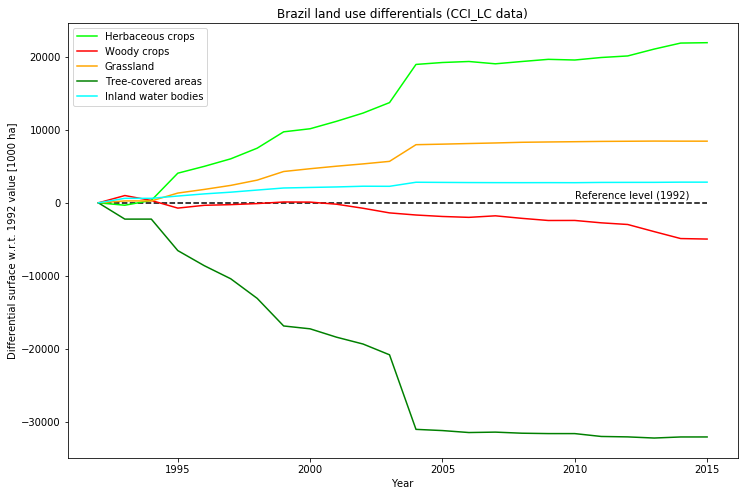

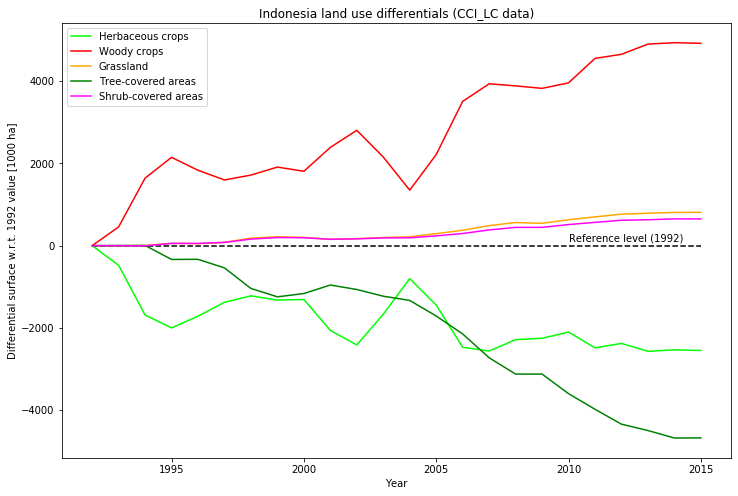

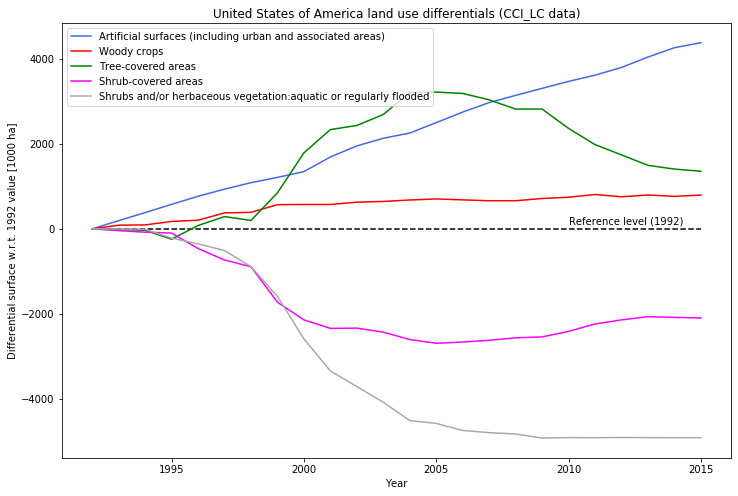

In [121]:
# Brazil
plot_land_type_differentials('Brazil', 'CCI_LC', 5)

# Indonesia
plot_land_type_differentials('Indonesia', 'CCI_LC', 5)

# United States of America
plot_land_type_differentials('United States of America', 'CCI_LC', 5)

> #### ***Explanation***
>
> Here we represented plots for Brazil and Indonesia (which are among the biggest deforested countries) and USA (which, instead, increased the forest land).
>
> + **BRAZIL**: big decrease in tree-covered areas, compensated by creation of **new grasslands and fields of herbaceous crops** (Brazil agriculture is mostly based on **sugar cane**).
> + **INDONESIA**: in this case also herbaceous crops fields decrease to compensate the **increase of woody crops** (cultivated trees). This is linked to the main product of indonesian agriculture: **palm oil**.
> + **UNITED STATES OF AMERICA**: in this case tree-covered areas increased **subtracting land to shrubs** and other small vegetation lands.

## **2. The Wood Trade**
Now, based on `Forestry_E_All_Data_cleared.csv` and `Forestry_Trade_Flows_E_All_Data_cleared.csv`, we start to look for the **biggest producers and consumers of wood** in the world.

In [3]:
# load Forestry data
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')

In [4]:
PRIMARY_FORREST_PRODUCTS = ['Roundwood', 'Sawnwood']

# the top 10 countries by deforested land area since 2010 (incl.)
DEC_FOREST = ['Brazil', 'Indonesia', 'Myanmar', 'Nigeria',
                  'United Republic of Tanzania', 'Paraguay', 'Zimbabwe',
                  'Democratic Republic of the Congo', 'Argentina',
                  'Bolivia (Plurinational State of)']

# the top 10 countries by forested land area since 2010 (incl.)
INC_FOREST = ['France', 'Viet Nam', 'India', "Lao People's Democratic Republic",
                'Gabon', 'Philippines', 'United States of America', 'Chile',
                'Australia', 'China:mainland']

In [10]:
# the wood production of countries in m3
wood_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) &
                                forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS) &
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

# aggreaged production of wood since 2010
wp_agg = forest_all[(forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS)) & (forest_all.Year >= 2010) & (forest_all.Unit.str.match("m3")) & (forest_all.Element.str.match('Production')) & (forest_all.Area.isin(FAOSTAT_countries))]

In [11]:
# production of the wood in the world
world_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.str.startswith("World") &
                                forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS) &
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

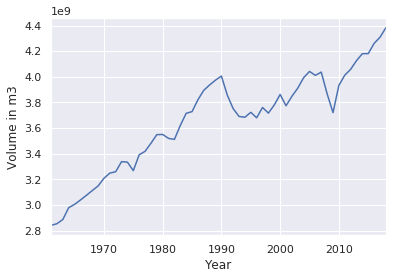

In [12]:
# the wood production in the world
world_production_m3.loc["World"].plot()
plt.ylabel("Volume in m3")
plt.show()

> #### ***Explanation***
Even though the decrease of the forest in the world seems to be constant, the production of the wood is increasing almost every year. The production has been increased by 15 percents in the last 10 years. This trend does not seem to be sustainable.

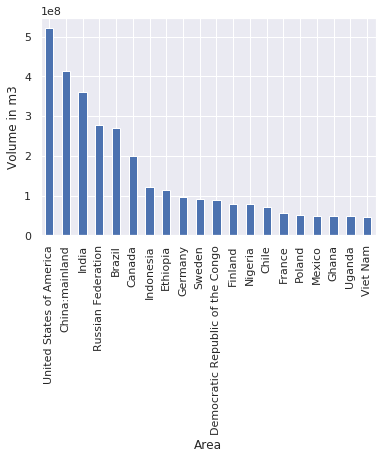

In [13]:
# the biggest producer of wood in 2018
wood_production_m3.loc[:, 2018].sort_values(ascending=False).head(20).plot.bar()
plt.ylabel("Volume in m3")
plt.show()

> #### ***Explanation***
The deforested/forested area in the country does not seem to be always correlated to the production of wood. We will investigate further the production of the wood in the countries which are leading in both deforesting and increasing the forested areas.

In [19]:
# rank countires by their wood production since 2010
wp_agg = wp_agg.groupby("Area").Value.sum()
wp_agg = wp_agg.to_frame()
wp_agg["rank"] = wp_agg.Value.rank(ascending=False)
wp_agg = wp_agg.reset_index()

In [20]:
# wood production of the top 10 countries by decreased forest area
wp_agg[wp_agg.Area.isin(DEC_FOREST)].sort_values(by='rank')

,Area,Value,rank
23,Brazil,2.431647e+09,4.0
88,Indonesia,1.117080e+09,7.0
51,Democratic Republic of the Congo,7.725738e+08,10.0
136,Nigeria,6.885227e+08,12.0
127,Myanmar,4.068526e+08,20.0
195,United Republic of Tanzania,2.388498e+08,32.0
5,Argentina,1.731315e+08,40.0
145,Paraguay,1.044092e+08,59.0
205,Zimbabwe,8.815796e+07,63.0
20,Bolivia (Plurinational State of),3.449735e+07,103.0


> #### ***Explanation***
Surprisingly, many of the countries which are leading in the reduction their forests (since 2010) are not one of the biggest producers of the wood in the world.

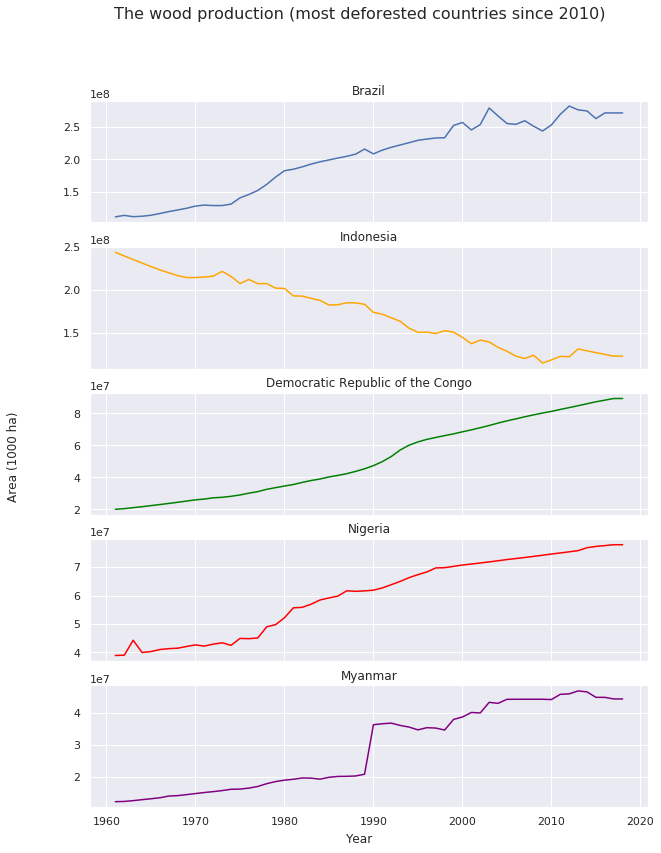

In [14]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))

axes[0].plot(wood_production_m3.loc['Brazil'])
axes[1].plot(wood_production_m3.loc['Indonesia'], color = 'orange')
axes[2].plot(wood_production_m3.loc['Democratic Republic of the Congo'], color = 'green')
axes[3].plot(wood_production_m3.loc['Nigeria'], color = 'red')
axes[4].plot(wood_production_m3.loc['Myanmar'], color = 'purple')
axes[0].set_title('Brazil')
axes[1].set_title('Indonesia')
axes[2].set_title('Democratic Republic of the Congo')
axes[3].set_title('Nigeria')
axes[4].set_title('Myanmar')
fig.suptitle("The wood production (most deforested countries since 2010)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
The countries that have suffered mostly by deforestation since the year 2010 don't seem to be slowing down, except the Indonesia, where is the value of the wood production decreasing year by year. This trend in Indonesia will most likely remain, since there is a big pressure from Indonesian president to reduce the deforestation ([link](https://www.weforum.org/agenda/2019/08/indonesia-president-makes-moratorium-on-forest-clearance-permanent/)).

In [21]:
# wood production of the top 10 countries by increased forest area
wp_agg[wp_agg.Area.isin(INC_FOREST)].sort_values(by='rank')

,Area,Value,rank
196,United States of America,4.285439e+09,1.0
39,China:mainland,3.616067e+09,2.0
87,India,3.269145e+09,3.0
35,Chile,5.871277e+08,14.0
68,France,5.400872e+08,15.0
201,Viet Nam,4.049915e+08,21.0
8,Australia,3.316286e+08,22.0
147,Philippines,1.474655e+08,44.0
102,Lao People's Democratic Republic,8.070786e+07,67.0
71,Gabon,3.374577e+07,105.0


> #### ***Explanation***
USA, China and India have appeared in the list of the top-10 countries which have increased their forested areas, but  these three countries are the biggest producers of the wood in the World!

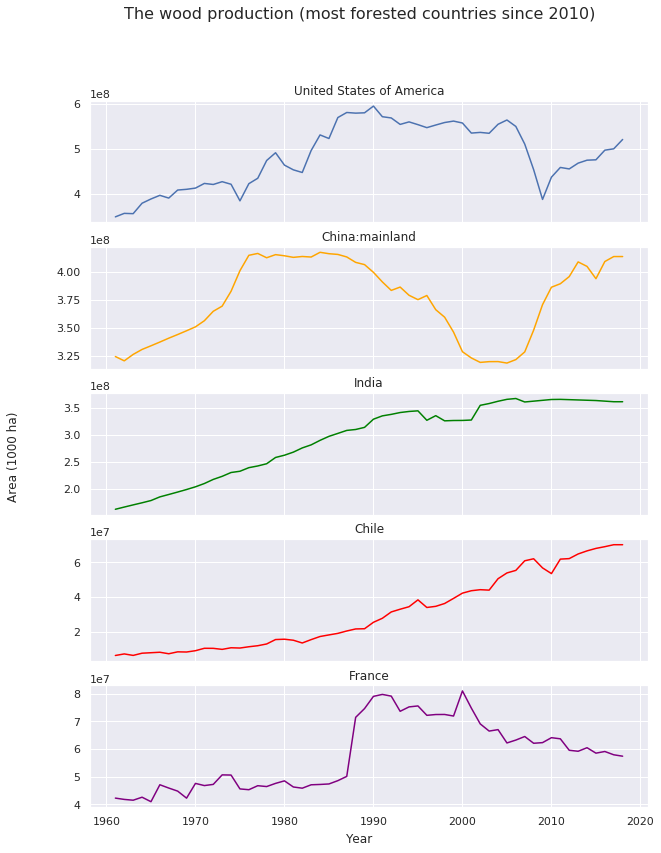

In [15]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))

axes[0].plot(wood_production_m3.loc['United States of America'])
axes[1].plot(wood_production_m3.loc['China:mainland'], color = 'orange')
axes[2].plot(wood_production_m3.loc['India'], color = 'green')
axes[3].plot(wood_production_m3.loc['Chile'], color = 'red')
axes[4].plot(wood_production_m3.loc['France'], color = 'purple')
axes[0].set_title('United States of America')
axes[1].set_title('China:mainland')
axes[2].set_title('India')
axes[3].set_title('Chile')
axes[4].set_title('France')
fig.suptitle("The wood production (most forested countries since 2010)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
When it comes to the countries where are the forested areas increasing, the value of the wood production are more variated.

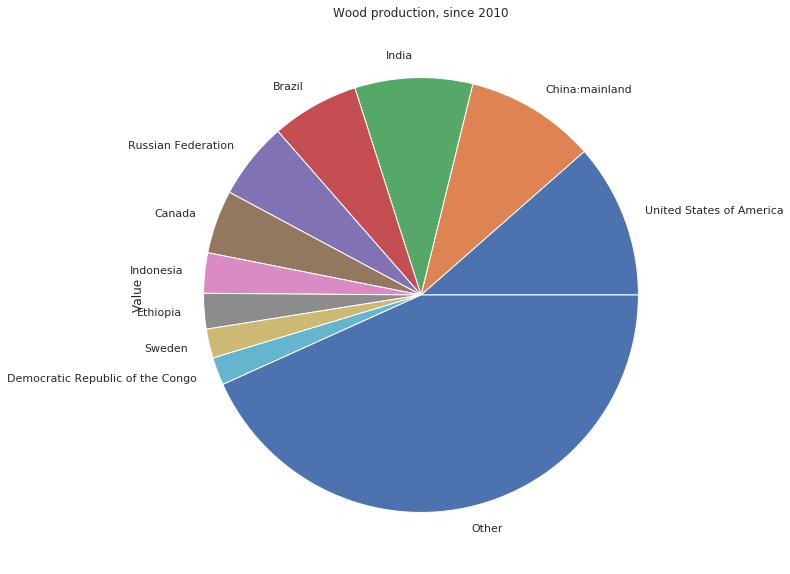

In [20]:
# plot the pie chart describing the wood production in the world since 2010
top_agg = wp_agg.sort_values(by='rank').head(10)[["Area", "Value"]]
oth = {"Area": ["Other"], "Value": [wp_agg.Value.sum() - top_agg.Value.sum()]}
top_agg =top_agg.append(pd.DataFrame.from_dict(oth), ignore_index=True)
top_agg.index = top_agg.Area

top_agg.plot.pie(y="Value", figsize=(10, 10), legend=False, title="Wood production, since 2010")
plt.show()

> #### ***Explanation***
Only **seven** countries in the world has been responsible for more than 50% produced wood since 2010. From this pie plot is much more clear how big is the share of the big wood producers such as USA, China or India. 

In [21]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "CHN"

# join the codes to the countires
wp_agg['Val_bil'] = wp_agg.Value / 1000000000
wp_map = wp_agg.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
#wp_map_2016 = wp_map[wp_map['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(wp_map, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlOrBr'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4285438664.0)
# define custom tick labels for color bar.

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('Production (10^9 m3)', '@Val_bil')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')
# create figure object
p = figure(title = 'Production of wood, since 2010', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# display figure
show(p)

Loading BokehJS ...

In [22]:
# create dataframe countaining the trade of the wood between countires (in 1000 US$)
trade_all = forest_trade[forest_trade.Element.str.match("Export Value")][["Reporter Countries", "Partner Countries", "Item", "Year", "Unit", "Value"]].rename(columns={"Reporter Countries": "Exporting Country", "Partner Countries": "Importing Country"})

# remove the total vaule of the trades
trade_all= trade_all[~trade_all["Importing Country"].str.match("Total FAO")]

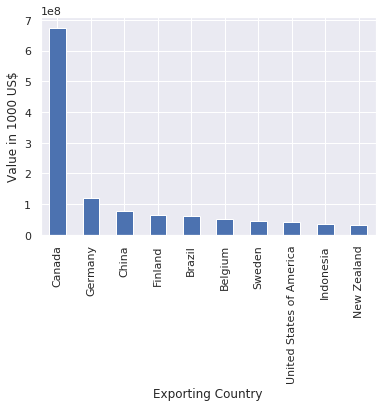

In [23]:
trade_all[trade_all["Importing Country"].isin(INC_FOREST)].groupby("Exporting Country").Value.sum().sort_values(ascending=False).head(10).plot.bar()
plt.ylabel("Value in 1000 US$")
plt.show()

> #### ***Explanation***
As we have been discussing, there are countries with increasing forested areas. We have been wondering if these countries have some big suppliers of the wood. We can see that there is enormous amount of wood coming to them form USA. We will look into this more deeply.

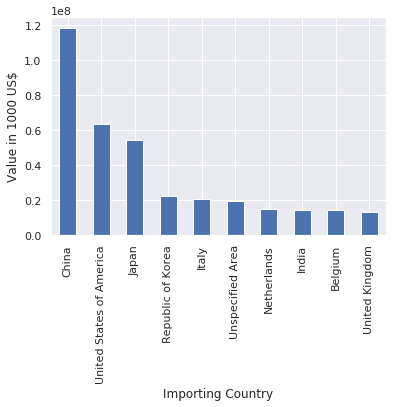

In [25]:
trade_all[trade_all["Exporting Country"].isin(DEC_FOREST)].groupby("Importing Country").Value.sum().sort_values(ascending=False).head(10).plot.bar()
plt.ylabel("Value in 1000 US$")
plt.show()

> #### ***Explanation***
We have decided to further investigate which countries are importing the wood from the most deforested countries. We an observe that the two biggest producers of the wood are the biggest importers of the wood from this countries.

In [26]:
# the list of biggest wood trade dependecies between countries
trade_all.groupby(["Importing Country", "Exporting Country"]).Value.sum().sort_values(ascending=False).head(20)

Importing Country         Exporting Country       
United States of America  Canada                      650458218.0
Canada                    United States of America    152072318.0
China                     United States of America    128389572.0
Germany                   Sweden                       99776352.0
China                     Russian Federation           94033854.0
Mexico                    United States of America     92689971.0
China                     Canada                       88742165.0
Germany                   Finland                      83120530.0
Japan                     United States of America     74458584.0
United Kingdom            Sweden                       72459379.0
France                    Germany                      71222433.0
Japan                     Canada                       64376362.0
China                     Indonesia                    63083492.0
United Kingdom            Finland                      57070875.0
Germany                  

> #### ***Explanation***
We can see how is the wood trade tied between the biggest Exporters/Importers in the World. We can see how is the USA wood market deepened on the production from Canada.


## **3. Is agricultural industry influencing deforestation?**
Here we used the datasets `Production_Crops_E_All_Data_cleared.csv` to try to link the deforestation to the type of agriculture performet in different countires.

### **3.1 Expansion of Agricultural Area**
In this part, we see the trend of agricultural areas expansion in each countries, intending to compare the result of the reduction of the forest areas.

In [4]:
# agricultural area (1000 ha) for each country per year
land_use_all.Area = np.where(land_use_all['Area'] == 'USSR', 'Russian Federation', land_use_all.Area)
land_use_ag = land_use_all[land_use_all.Item == 'Agriculture']
land_use_ag = land_use_ag[(land_use_ag.Area.isin(FAOSTAT_countries))]\
.groupby(["Area", "Year"])\
.Value.sum().unstack("Year")

In [5]:
# expansion of agricultural areas (2017 - 1997)
ag_areas_diff = land_use_ag.iloc[:, 56] - land_use_ag.iloc[:,36]
ag_areas_diff = ag_areas_diff.sort_values(ascending=False)

In [6]:
# top 5 countries which experienced the biggest expansion of agricultural area
ag_areas_diff.head(5)

Area
Argentina       20465.00
Indonesia       18773.00
Saudi Arabia    14827.00
Niger           10600.00
Brazil           7906.36
dtype: float64

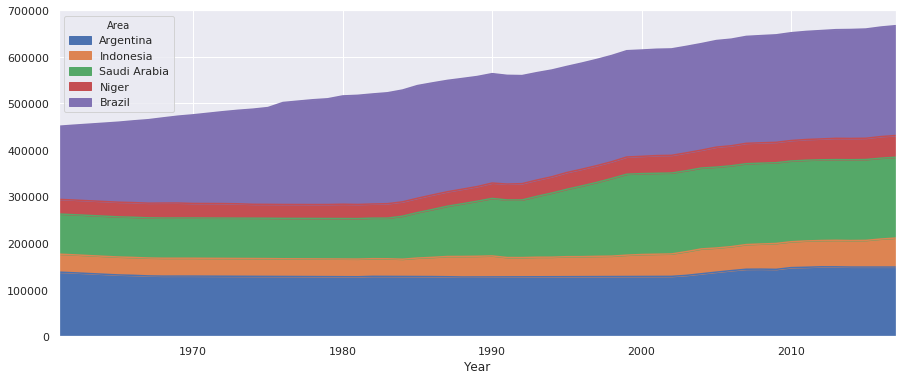

In [7]:
# plot the trend of agricultural areas in the 5 nations
land_use_ag.loc[ag_areas_diff[:5].index].T.plot.area(figsize=(15,6))

In [8]:
# forest areas (1000 ha) for each country per year
land_use_forest = land_use_all[land_use_all.Item == 'Forestry']
land_use_forest = land_use_forest[(land_use_forest.Area.isin(FAOSTAT_countries))]\
.groupby(["Area", "Year"])\
.Value.sum().unstack("Year")

In [9]:
# reduction of forest areas (2017 - 1997), minus values mean reduction of forest
forest_areas_diff = land_use_forest.iloc[:, 27] - land_use_forest.iloc[:,7]
forest_areas_diff = forest_areas_diff.sort_values(ascending=True)

In [10]:
# top 5 countries which experienced the biggest reduction of forest area
forest_areas_diff.head()

Area
Brazil                        -35365.3
Indonesia                     -14139.8
Nigeria                        -7373.1
Myanmar                        -7132.0
United Republic of Tanzania    -7060.0
dtype: float64

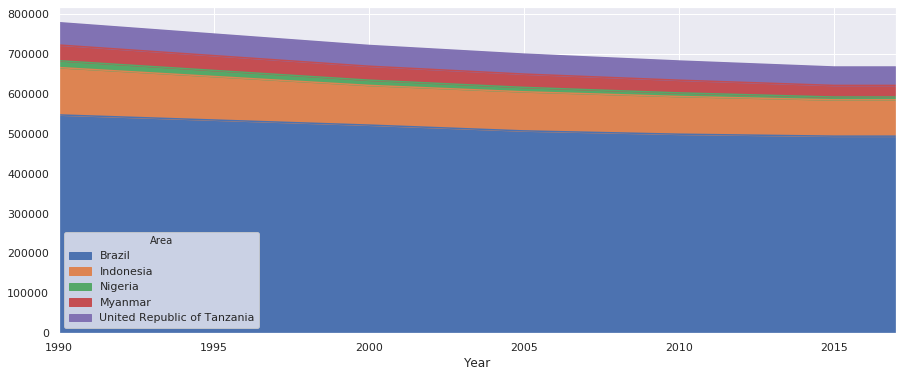

In [11]:
# plot the trend of forest areas in the 5 nations
land_use_forest.loc[forest_areas_diff[:5].index].T.plot.area(figsize=(15,6))

In [12]:
# dataframe to compare deforestation and expantion of agricultural area
df_concat = pd.concat([forest_areas_diff, ag_areas_diff], axis=1, sort=False)
df_concat.columns = ['d_ForestArea','d_AgriculturalArea']

df_concat = df_concat.sort_values(by=['d_AgriculturalArea'], ascending=False)
df_concat.head(10)

,d_ForestArea,d_AgriculturalArea
Argentina,-5627.90,20465.00
Indonesia,-14139.80,18773.00
Saudi Arabia,0.00,14827.00
Niger,-371.10,10600.00
Brazil,-35365.30,7906.36
Ethiopia,-1628.70,7048.10
United Republic of Tanzania,-7060.00,5947.00
Democratic Republic of the Congo,-5605.20,5828.00
China:mainland,37278.77,4400.00
Viet Nam,3755.20,4324.80


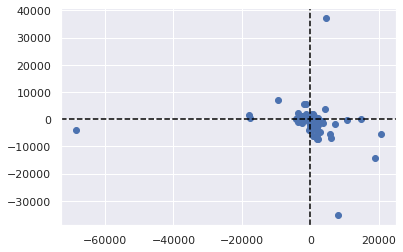

In [13]:
# create plot to find correlation between deforestation and expansion of agricultural area
fig = plt.figure()
ax = plt.subplot()
plt.scatter(df_concat.d_AgriculturalArea, df_concat.d_ForestArea)
plt.axvline(x=0,color='black', linestyle='--')
plt.axhline(y=0,color='black', linestyle='--')
plt.show()

In [14]:
# outlier 1: Australia
df_concat.loc['Australia']

d_ForestArea          -4000.0
d_AgriculturalArea   -68403.0
Name: Australia, dtype: float64

In [15]:
land_use_ag.loc['Australia'].tail(20)

Year
1998    463786.0
1999    453729.0
2000    455500.0
2001    455700.0
2002    447000.0
2003    439500.0
2004    440110.0
2005    445149.0
2006    434925.0
2007    425449.0
2008    417288.0
2009    409029.0
2010    398580.0
2011    409672.6
2012    405474.0
2013    396615.3
2014    406269.0
2015    365913.0
2016    371078.0
2017    393797.0
Name: Australia, dtype: float64

Australia has continuous down trend in its agricultural area. Its by far much steeper than other country. We exclude Australia from the scattered plot.

In [16]:
# outlier 2: China:mainland
df_concat.loc['China:mainland']

d_ForestArea          37278.77
d_AgriculturalArea     4400.00
Name: China:mainland, dtype: float64

As explained in part 1, China:mainland enlarges its forest area by its continuous tree planting activity. This seems to draw out the effect of agricultural area expansion. So, we exclude China:mainland from the scattered plot.

(-10000, 5000)

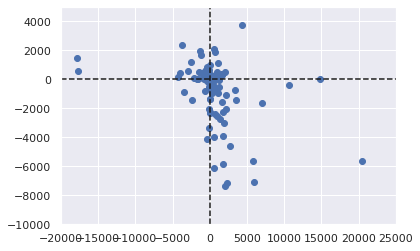

In [17]:
# reset xrange and yrange so that the outliers are excluded
fig = plt.figure()
ax = plt.subplot()
plt.scatter(df_concat.d_AgriculturalArea, df_concat.d_ForestArea)
plt.axvline(x=0,color='k', linestyle='--')
plt.axhline(y=0,color='k', linestyle='--')
ax.set_xlim(-20000,25000)
ax.set_ylim(-10000,5000)

> #### Explanation
> - We found slightly negative correlation between expansion of agrecultural areas and forest areas. However, the conrrelation is not as stong as we expected.
> - Considering only the expantion of agricultural areas is not enough to explain the main causes of deforestation. We need to consider other features such as timber production in the nation and planting activities as well.

### **3.2 Link between yield of agricultural land and deforestation**
Here we try to check if agricultural yield can be used useful in classifying the countries in de- and re-foresting ones.

In [106]:
prod_crops_all = pd.read_csv("data/faostat/Production_Crops_E_All_Data_cleared.csv", engine='python')

In [143]:
# Correlation between low yield and high deforestation.
# The field 'Yield' in the 'Element' column of the dataframe is computed
# as 'Production' / 'Area Harvested' and measured in hg/ha
def yield_differences_in_top_10s(ITEM, YEAR):
    deforested_values = prod_crops_all.loc[(prod_crops_all.Area.isin(top_10_deforested_countries)) &
                                           (prod_crops_all.Item == ITEM) &
                                           (prod_crops_all.Year == YEAR) &
                                           (prod_crops_all.Element == 'Yield')]\
                                      .loc[:, ['Value', 'Area']]

    reforested_values = prod_crops_all.loc[(prod_crops_all.Area.isin(top_10_reforested_countries)) &
                                           (prod_crops_all.Item == ITEM) &
                                           (prod_crops_all.Year == YEAR) &
                                           (prod_crops_all.Element == 'Yield')]\
                                      .loc[:, ['Value', 'Area']]

    reforested_values['Deforested'] = 0
    reforested_values['Color'] = 'royalblue'
    deforested_values['Deforested'] = 1
    deforested_values['Color'] = 'orange'
    all_values = pd.concat([deforested_values, reforested_values], axis=0)
    all_values = all_values.sort_values(by=['Value'])

    # print(ITEM + ' yield:\n' +
    #       str(deforested_values.Value.mean()) + ' (mean over ' + str(deforested_values.Value.count()) + ' countries in top 10 deforested)\n' + 
    #       str(reforested_values.Value.mean()) + ' (mean over ' + str(reforested_values.Value.count()) + ' countries in top 10 reforested)')

    plt.figure(figsize=(9, 6))
    for country in all_values.Area:
        plt.barh(country, all_values.loc[all_values.Area == country, 'Value'], color=all_values.loc[all_values.Area == country, 'Color'])
    plt.legend(['reforested (== blue)', 'deforested (== orange)'])
    plt.title(ITEM + ' yield in top 10 reforested and deforested countries (year ' + str(YEAR) + ')')
    plt.gca().set_xlabel('Yield [hg/ha]')
    plt.show()

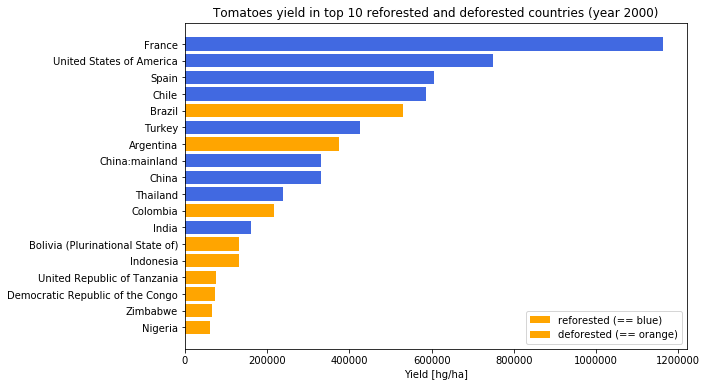

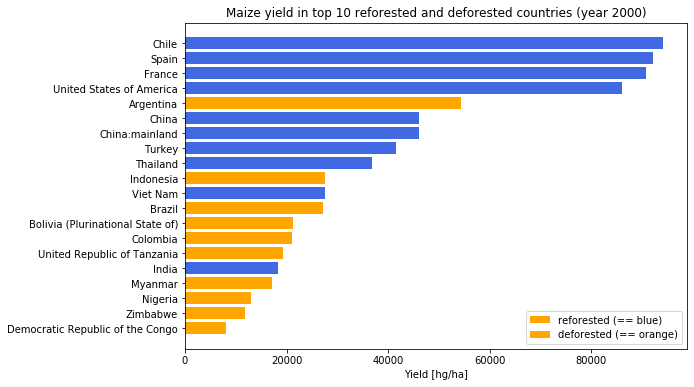

In [144]:
yield_differences_in_top_10s('Tomatoes', 2000)
yield_differences_in_top_10s('Maize', 2000)

> #### ***Explanation***
> Countries that **increased their forest land** (USA, Chine, Thailand, France, Spain...) have usually a much **bigger yield**. Yield is computed as production over area harvested and it is than measured in hg/ha. This can be interpreted as: **better productivity means less need of agriculture land** to product the same quantity, alleviating the need of new lands to cultivate. Anyway **this conclusion is weak** since the clear correlation exibithed in the previous plots can be explained also by a more general cause: deforesting countries are on average less rich than the ones that increase tree coverage; **richer countries have access to better agricultural practices** that increase productivity (e.g. check for India, developing country, which has low productivity scores).
>
> (TODO: fix problem with the legend for the data story!)

### **3.3 Clustering of the countries based on agricultural production share**
In this section we want to **understand if the deforesting countries have similar agriculture styles**. **PCA** is used to classify the countries based on their agricultural production in a 2D space. A matrix containing countries (as rows) and **shares in agricultural production** of each type of product (each item is a column) is used as a representation of different agriculture styles.

In [148]:
# compute the share of each agriculture item for every country, selected year
YEAR = 2015

countries_production_total = prod_crops_all.loc[(prod_crops_all.Element == 'Production')]\
                                           .groupby(['Area', 'Year'])\
                                           .sum()\
                                           .rename({'Value': 'Total Yearly Production'}, axis='columns')\
                                           .loc[:, 'Total Yearly Production']

countries_production_shares = prod_crops_all.loc[(prod_crops_all.Element == 'Production')]\
                                            .merge(countries_production_total, right_index=True, left_on=['Area', 'Year'])

countries_production_shares['Yearly Share'] = 100 * countries_production_shares['Value'] / countries_production_shares['Total Yearly Production']

# remove aggregated areas
countries_production_shares = countries_production_shares.loc[countries_production_shares['Area Code'] < 5000]

# select a single year
shares_single_year = countries_production_shares.loc[countries_production_shares.Year == YEAR]

In [ ]:
# build the matrix for PCA: rows are countries, columns are agricoltural products; values are shares (%) of total yearly production
%%time
production_shares_matrix = pd.DataFrame(index=shares_single_year['Area'].unique(), columns=shares_single_year['Item'].unique())
row_names = production_shares_matrix.index
col_names = production_shares_matrix.columns
for row_index in range(0, production_shares_matrix.shape[0]):
    for col_index in range(0, production_shares_matrix.shape[1]):
        values = shares_single_year.loc[(shares_single_year.Area == row_names[row_index]) & 
                                        (shares_single_year.Item == col_names[col_index])]\
                                   .loc[:, 'Yearly Share']\
                                   .values
        if values.size == 0:
            production_shares_matrix.iloc[row_index, col_index] = 0
        else:
            if np.isnan(values[0]):
                production_shares_matrix.iloc[row_index, col_index] = 0
            else:
                production_shares_matrix.iloc[row_index, col_index] = values[0]
                
# export and save in pickle format
production_shares_matrix.to_pickle("./production_shares_matrix.pkl")

In [169]:
# show a sample of the matrix used for clustring
production_shares_matrix.iloc[0:4, 0:4]

,Almonds:with shell,Anise:badian:fennel:coriander,Apples,Apricots
Afghanistan,0.0976835,0.0725193,0.361521,0.353274
Albania,0,0,1.45978,0.0802803
Algeria,0.157873,0,0.931925,0.605811
American Samoa,0,0,0,0


In [151]:
# find top 10 re- and de-forester countries indices (rows) in the matrix
deforester_indices = []
reforester_indices = []
for i in range(0, production_shares_matrix.shape[0]):
    if production_shares_matrix.index[i] in top_10_deforested_countries.values:
        deforester_indices.append(i)
    elif production_shares_matrix.index[i] in top_10_reforested_countries.values:
        reforester_indices.append(i)
        
# compute the reduced matrix (only 20 countries from the two top 10) before applying SVD
reduced_production_shares_matrix = production_shares_matrix.loc[production_shares_matrix.index.isin(top_10_deforested_countries.values.tolist() + 
                                                                                                    top_10_reforested_countries.values.tolist())]

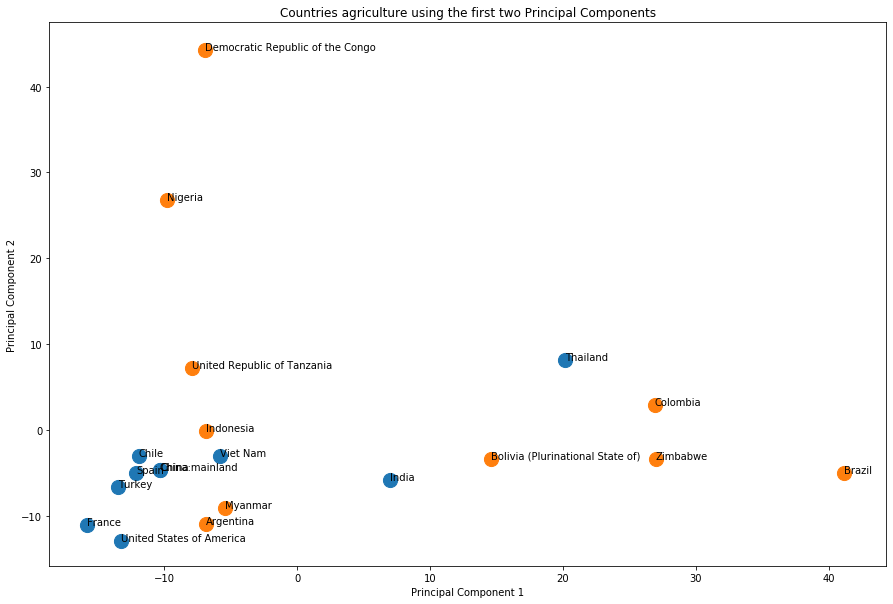

In [167]:
from sklearn.decomposition import PCA

# matrix rows are countries, columns are products; values are shares (%) of total yearly production
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(reduced_production_shares_matrix.values)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# plot results in 2D and look for clusters
plt.figure(figsize=(15, 10))
plt.scatter(principalDf.PC1[reduced_reforester_indices], principalDf.PC2[reduced_reforester_indices], marker='o', s=200)
plt.scatter(principalDf.PC1[reduced_deforester_indices], principalDf.PC2[reduced_deforester_indices], marker='o', s=200)
# add country names to the plot
for i, country in enumerate(reduced_production_shares_matrix.index.values[reduced_reforester_indices]):
    plt.annotate(country, (principalDf.PC1[reduced_reforester_indices[i]], principalDf.PC2[reduced_reforester_indices[i]]))
for i, country in enumerate(reduced_production_shares_matrix.index.values[reduced_deforester_indices]):
    plt.annotate(country, (principalDf.PC1[reduced_deforester_indices[i]], principalDf.PC2[reduced_deforester_indices[i]]))
plt.title('Countries agriculture using the first two Principal Components')
plt.gca().set_xlabel('Principal Component 1')
plt.gca().set_ylabel('Principal Component 2')
plt.show()

In [166]:
# first 10 singular values
print("First 6 singular values:\n", pca.singular_values_, end='\n\n')

# variance explanation ratio for each singular value
print("Variance explanation of the first 6 singular values:\n", pca.explained_variance_ratio_)

First 6 singular values:
 [72.7103547  59.36180494 36.38818324 30.07216008 24.19752362 18.66247835]

Variance explanation of the first 6 singular values:
 [0.41425953 0.27611766 0.10375302 0.07086132 0.04587983 0.02729095]


>#### ***Explanation***
> **PCA** is used to classify the countries based on their agricultural production in a 2D space.
> + Pros:
>
>   + Simple **visual** clustering.
>
>   + **Deforesting countries** (orange) **have a more spread distribution** and are on average far from the blue cluster of countries that increase forest land. 
>
> + Cons: 
>
>   + **Lack of interpretability** since the dimensions does not have a physical meaning.
>
>   + The clustering in two classes is far from perfect.
>   
>   + The difference between the two biggest singular values and the others is not so high (the third is about half the second): **not-negligible variations are thrown away** with just 2 dimensions.

#### 4. Future Work
1. Select a way to fillout empty value in time series data.
> Choose a better way for our dataset (Linear interporation / polynominal interporation/ others)
2. Find out other features that have impact on forest areas and caluculate the corellation beween deforestation and these features. 
> Candidate of the feature are: Growth of Artificial areas, amount of timber products, and activities of planting tree. Linear regression with mutiple variable is a possible way to calculate the correlation. The regresshon model could be as follows.
$$ DF = w_1 AA + w_2 TP + w_3 PT + \sum_i w_i OF $$
DF: Deforestation [ha /yr],<br>
AA: Expansion of Agricaltural Area [ha/yr],<br>
TP: Timber Production [m3/yr],<br>
PT: Planting Tree Activities [ha/yr],<br>
OF: Other Factors (To be defined)

3. Different approach to explain deforestation

4. For the schedule, please refer to our README.

## **APPENDIX: datasets summaries**

#### Inputs_LandUse_E_All_Data_cleared.csv
+ **Unit**: [**'1000 ha'**, 'million tonnes']
+ **Item**: ['Country area', 'Land area', 'Agriculture', ..., **'Forestry'**, **'Forest land'**, **'Primary Forest'**, ..., **'Farm buildings & farmyards'**, 'Perm. meadows & pastures area certified organic', ...]
+ **Element**: ['Area', 'Carbon stock in living biomass']

#### Environment_LandUse_E_All_Data_cleared.csv
+ **Unit**: [**'%'**]
+ **Item**: ['Arable land', 'Land under permanent crops', 'Cropland', 'Land under perm. meadows and pastures', 'Agriculture area actually irrigated', 'Land area equipped for irrigation', 'Agricultural land', **'Forest land'**, **'Primary Forest'**, **'Planted Forest'**, **'Other naturally regenerated forest'**, 'Agriculture area under organic agric.']
+ **Element**: ['Share in Agricultural land', **'Share in Land area'**, **'Share in Forest land'**]

#### Environment_LandCover_E_All_Data_cleared.csv
+ **Unit**: ['1000 ha']
+ **Item**: ['Artificial surfaces (including urban and associated areas)', **'Herbaceous crops'**, **'Woody crops'**, 'Multiple or layered crops', **'Grassland'**, **'Tree-covered areas'**, 'Mangroves', 'Shrub-covered areas', 'Shrubs and/or herbaceous vegetation:aquatic or regularly flooded', 'Sparsely natural vegetated areas', 'Terrestrial barren land', 'Permanent snow and glaciers', 'Inland water bodies', 'Coastal water bodies and intertidal areas']
+ **Element**: ['Area from **MODIS**', 'Area from **CCI_LC**']

#### Production_CropsProcessed_E_All_Data_cleared.csv
+ **Unit**: ['tonnes']
+ **Item**: ['Cotton lint', 'Cottonseed', 'Molasses', 'Oil:cottonseed', ..., **'Oil:palm kernel'**, 'Palm kernels', 'Oil:maize']
+ **Element**: ['Production']

#### Production_Crops_E_All_Data_cleared.csv
+ **Unit**: ['ha', 'hg/ha', 'tonnes']
+ **Item**: ['Almonds:with shell', 'Anise:badian:fennel:coriander', 'Apples', ..., ..., **'Soybeans'**, ..., ..., ..., ..., 'Fruit:pome nes']
+ **Element**: [**'Area harvested'**, **'Yield'**, **'Production'**]

#### Environment_LivestockPatterns_E_All_Data_cleared.csv
+ **Unit**: [**'LSU/ha'**, '% of total LSU', **'Livestock units (LSU)'**]
+ **Item**: ['Asses', 'Camels', **'Cattle'**, 'Chickens', 'Goats', 'Horses', 'Mules', 'Sheep', 'Cattle and Buffaloes', 'Sheep and Goats', 'Equidae', **'Major livestock types'**, 'Buffaloes', 'Pigs']
+ **Element**: ['Livestock units per agricultural land area', 'Share in total livestock', 'Stocks']

#### Production_LivestockProcessed_E_All_Data_cleared.csv
+ **Unit**: ['tonnes']
+ **Item**: ['Butter and ghee:sheep milk', 'Butter:cow milk', ..., 'Cheese:buffalo milk', 'Butter of goat mlk']
+ **Element**: ['Production']

#### Production_LivestockPrimary_E_All_Data_cleared.csv
+ **Unit**: ['1000 Head', '100mg/An', 'tonnes', '1000 No', **'Head'**, 'hg/An', '0.1g/An', 'hg', 'No']
+ **Item**: ['Eggs:hen:in shell', 'Eggs:hen:in shell (number)', 'Hides:cattle:fresh', 'Honey:natural', 'Meat indigenous:camel', **'Meat indigenous:cattle'**, ..., Snails:not sea', 'Hair:horse']
+ **Element**: ['Laying', 'Yield', 'Production', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight', 'Milk Animals', 'Prod Popultn']